# 使用wine_benchmark做异常点检测 

In [1]:
import pyod
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA 
import tensorflow

In [2]:
meta_data = pd.read_csv('D:/homework_for_data_mining/outlier detection/wine/meta_data/wine.preproc.csv', encoding='utf-8')

In [3]:
ground_truth = meta_data[['ground.truth']]
normal = ground_truth[ground_truth['ground.truth']=='nominal']
anomaly = ground_truth[ground_truth['ground.truth']=='anomaly']
normal_len = len(normal.index)
anomaly_len = len(anomaly.index)
total_len = normal_len + anomaly_len
print('nominal ', normal_len/total_len)
print('anamaly ', anomaly_len/total_len)

nominal  0.6330614129598277
anamaly  0.3669385870401724


# 按照9:1的比例划分训练集和测试集

保证在训练集上异常点的比例小于正常点，把benchmark中的异常点的label转化为二值，1代表异常点，0代表正常点

In [7]:
test_set_index, train_set_index = [], []
normal_index = normal.index
total_normal_index = np.arange(normal_len)
normal_test_index = np.random.choice(total_normal_index, size=int(normal_len * 0.1), replace=False)
normal_train_index = [_index for _index in total_normal_index if _index not in normal_test_index]
test_set_index = normal_index[normal_test_index]
train_set_index = normal_index[normal_train_index]

anomaly_index = anomaly.index
total_anomaly_index = np.arange(anomaly_len)
anomaly_test_index = np.random.choice(total_anomaly_index, size=int(anomaly_len*0.1), replace=False)
anomaly_train_index = [_index for _index in total_anomaly_index if _index not in anomaly_test_index]
test_set_index =  test_set_index.append(anomaly_index[anomaly_test_index])
train_set_index = train_set_index.append(anomaly_index[anomaly_train_index])

train_set_feature = meta_data.loc[train_set_index, ['fixed.acidity','volatile.acidity','citric.acid','residual.sugar','chlorides','free.sulfur.dioxide','total.sulfur.dioxide','density','pH','sulphates','alcohol']]
train_set_feature = np.array(train_set_feature.values.tolist())
test_set_feature = meta_data.loc[test_set_index, ['fixed.acidity','volatile.acidity','citric.acid','residual.sugar','chlorides','free.sulfur.dioxide','total.sulfur.dioxide','density','pH','sulphates','alcohol']]
test_set_feature = np.array(test_set_feature.values.tolist())
# print(test_set_index)
train_set_groundtruth = meta_data.loc[train_set_index, 'ground.truth'].values.tolist()
test_set_groundtruth = meta_data.loc[test_set_index, 'ground.truth'].values.tolist()
y_train_label = np.array([0 if _label == 'nominal' else 1 for _label in train_set_groundtruth ])
y_test_label = np.array([0 if _label == 'nominal' else 1 for _label in test_set_groundtruth ])

# 使用KNN进行异常点分析

## 计算ROC-AUC分数 

In [8]:
from pyod.models.knn import KNN
from pyod.utils.utility import precision_n_scores
from sklearn.metrics import roc_auc_score
clf = KNN()
clf.fit(train_set_feature)
y_train_pred = clf.labels_
y_train_score = clf.decision_scores_

y_test_pred = clf.predict(test_set_feature)
y_test_score = clf.decision_function(test_set_feature)

print('Train AUC:{roc}, precision:{prn}'.format(
    roc=roc_auc_score(y_train_label, y_train_score),
    prn=precision_n_scores(y_train_label, y_train_score)))

print('Test AUC:{roc}, precision:{prn}'.format(
    roc=roc_auc_score(y_test_label, y_test_score),
    prn=precision_n_scores(y_test_label, y_test_score)))

Train AUC:0.5527476907234282, precision:0.40882597835137385
Test AUC:0.5488403211418376, precision:0.39097744360902253


可以看出，使用KNN方法在训练集和测试集上的AUC分数都在0.5-0.7之间，异常点识别效果较低。

## 使用PCA对数据特征进行降维后可视化 

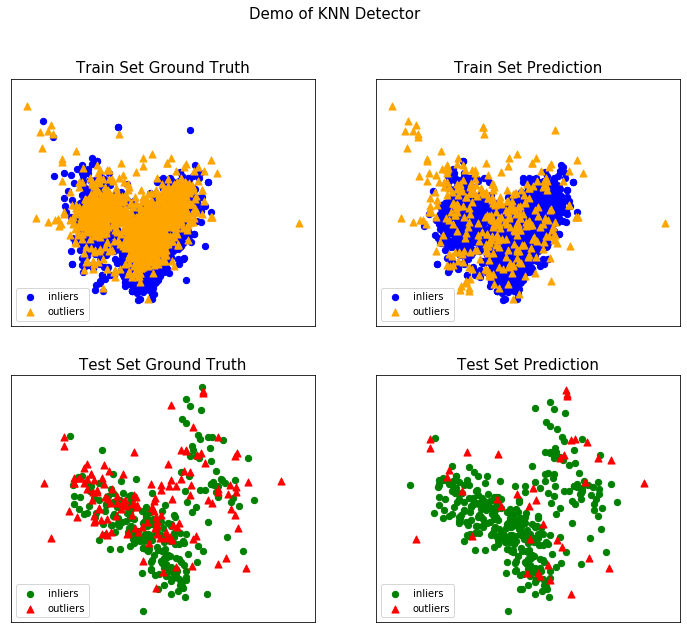

In [9]:
from pyod.utils.example import visualize
pca = PCA(n_components=2)
reduced_train_set_feature = pca.fit_transform(train_set_feature)
pca_test = PCA(n_components=2)
reduced_test_set_feature = pca_test.fit_transform(test_set_feature)
clf_name = 'KNN'
visualize(clf_name, reduced_train_set_feature, y_train_label, reduced_test_set_feature, y_test_label, y_train_pred, y_test_pred, show_figure=True, save_figure=False)

KNN方法是一种无监督的方法。从图中可以看出，使用KNN方法进行异常点识别的效果较差，很多异常点没有识别出来。

# 使用IForest进行异常点分析

## 计算ROC-AUC分数并可视化 

Train AUC:0.5477588804141571, precision:0.40882597835137385
Test AUC:0.594335414808207, precision:0.45864661654135336


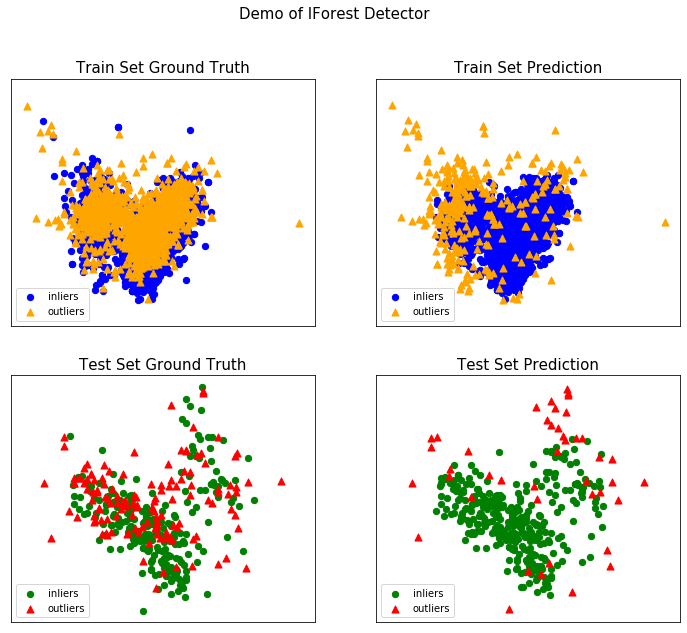

In [10]:
from pyod.models.iforest import IForest

clf = IForest()
clf.fit(train_set_feature)
y_train_pred = clf.labels_
y_train_score = clf.decision_scores_

y_test_pred = clf.predict(test_set_feature)
y_test_score = clf.decision_function(test_set_feature)

print('Train AUC:{roc}, precision:{prn}'.format(
    roc=roc_auc_score(y_train_label, y_train_score),
    prn=precision_n_scores(y_train_label, y_train_score)))

print('Test AUC:{roc}, precision:{prn}'.format(
    roc=roc_auc_score(y_test_label, y_test_score),
    prn=precision_n_scores(y_test_label, y_test_score)))
pca = PCA(n_components=2)
reduced_train_set_feature = pca.fit_transform(train_set_feature)
pca_test = PCA(n_components=2)
reduced_test_set_feature = pca_test.fit_transform(test_set_feature)
clf_name = 'IForest'
visualize(clf_name, reduced_train_set_feature, y_train_label, reduced_test_set_feature, y_test_label, y_train_pred, y_test_pred, show_figure=True, save_figure=False)

可以看出，IForest算法对于大部分明显偏离正常点的数据都识别成了异常点。如果从降维的两个主成分的角度来看，IForest是合格的，因为他确实把远离中心的异常点都识别了出来，但是很明显groundtruth不是这么定义的，一些异常点在图像中也在正常点的内部。理论上来说，IForest是适合高维数据的，但是在这个benchmark上，IForest不适合。这可能是由于在IForest算法中，每次切数据空间都是随机选取一个维度，建完树后仍然有大量的维度信息没有被使用，导致算法在高维空间下可靠性降低。

# 使用LOF进行异常点分析 

## 计算ROC-AUC分数并可视化  

Train AUC:0.5485427247882586, precision:0.4096586178184846
Test AUC:0.5582706766917294, precision:0.40601503759398494


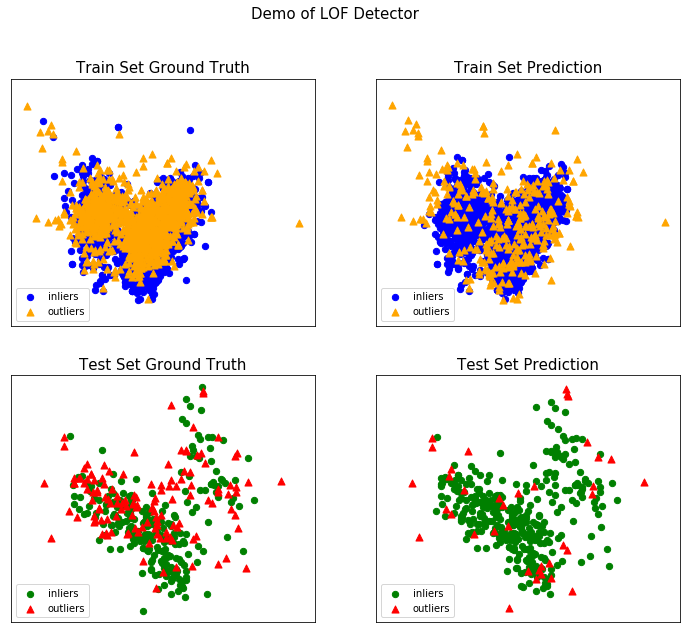

In [11]:
from pyod.models.lof import LOF

clf = LOF()
clf.fit(train_set_feature)
y_train_pred = clf.labels_
y_train_score = clf.decision_scores_

y_test_pred = clf.predict(test_set_feature)
y_test_score = clf.decision_function(test_set_feature)

print('Train AUC:{roc}, precision:{prn}'.format(
    roc=roc_auc_score(y_train_label, y_train_score),
    prn=precision_n_scores(y_train_label, y_train_score)))

print('Test AUC:{roc}, precision:{prn}'.format(
    roc=roc_auc_score(y_test_label, y_test_score),
    prn=precision_n_scores(y_test_label, y_test_score)))
pca = PCA(n_components=2)
reduced_train_set_feature = pca.fit_transform(train_set_feature)
pca_test = PCA(n_components=2)
reduced_test_set_feature = pca_test.fit_transform(test_set_feature)
clf_name = 'LOF'
visualize(clf_name, reduced_train_set_feature, y_train_label, reduced_test_set_feature, y_test_label, y_train_pred, y_test_pred, show_figure=True, save_figure=False)

尽管LOF算法的AUC值也没有很高，但是LOF算法能够把一些在高维上异常，但是在降维后的空间中处于正常点内部的异常点检查出来。如果，LOF算法能够把一些绿色区域的红色点检测出来，同样对于明显的异常点有准确的检测。在这一点上，LOF算法要比IForest算法要好。

# 使用OCSVM进行异常点分析 

## 计算ROC-AUC分数并可视化  

Train AUC:0.5395534975737128, precision:0.4063280599500416
Test AUC:0.5756340002548745, precision:0.44360902255639095


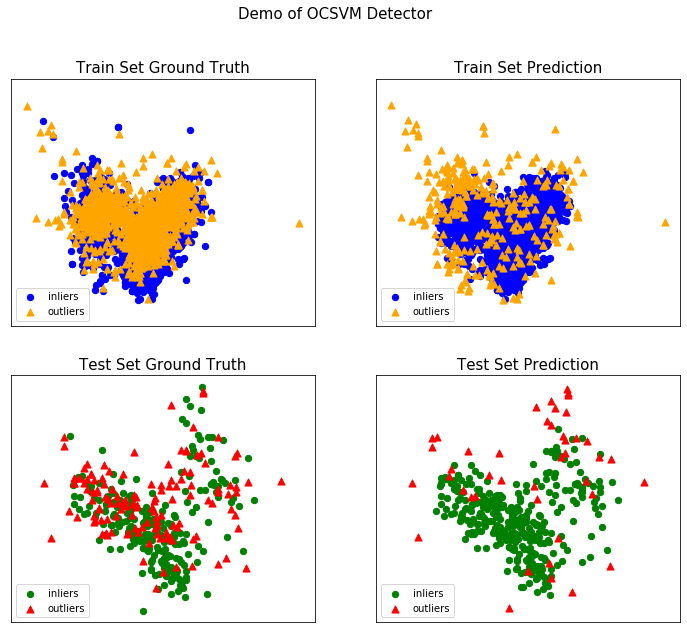

In [12]:
from pyod.models.ocsvm import OCSVM

clf = OCSVM()
clf.fit(train_set_feature)
y_train_pred = clf.labels_
y_train_score = clf.decision_scores_

y_test_pred = clf.predict(test_set_feature)
y_test_score = clf.decision_function(test_set_feature)

print('Train AUC:{roc}, precision:{prn}'.format(
    roc=roc_auc_score(y_train_label, y_train_score),
    prn=precision_n_scores(y_train_label, y_train_score)))

print('Test AUC:{roc}, precision:{prn}'.format(
    roc=roc_auc_score(y_test_label, y_test_score),
    prn=precision_n_scores(y_test_label, y_test_score)))
pca = PCA(n_components=2)
reduced_train_set_feature = pca.fit_transform(train_set_feature)
pca_test = PCA(n_components=2)
reduced_test_set_feature = pca_test.fit_transform(test_set_feature)
clf_name = 'OCSVM'
visualize(clf_name, reduced_train_set_feature, y_train_label, reduced_test_set_feature, y_test_label, y_train_pred, y_test_pred, show_figure=True, save_figure=False)

# 全benchmark异常值分析 

最后，在所有wave_benchmark上，使用KNN、IForest、LOF和OCSVM异常值检测算法进行异常值检测，并把评估结果存储在wine_benchmark_result.csv中。

In [18]:
import os
import csv

root_path = 'D:/homework_for_data_mining/outlier detection/wine/benchmarks/'
csv_file_name = 'D:/homework_for_data_mining/outlier detection/wine/wine_benchmark_result.csv'
csv_file = open(csv_file_name, 'w', newline='')
csv_writer = csv.writer(csv_file)
csv_writer.writerow(['file name', 'KNN-ROC', 'IForest-ROC', 'LOF-ROC', 'OCSVM-ROC'])
all_file = os.listdir(root_path)

for file_name in all_file:
    file_path = root_path + file_name
    meta_data = pd.read_csv(file_path, encoding='utf-8')
    ground_truth = meta_data[['ground.truth']]
    normal = ground_truth[ground_truth['ground.truth']=='nominal']
    anomaly = ground_truth[ground_truth['ground.truth']=='anomaly']
    normal_len = len(normal.index)
    anomaly_len = len(anomaly.index)
    total_len = normal_len + anomaly_len
    print(file_name)
    if anomaly_len >= normal_len or anomaly_len <=10:
        continue
    
    test_set_index, train_set_index = [], []
    normal_index = normal.index
    total_normal_index = np.arange(normal_len)
    
    normal_test_index = np.random.choice(total_normal_index, size=int(normal_len * 0.1), replace=False)
    normal_train_index = [_index for _index in total_normal_index if _index not in normal_test_index]
    test_set_index = normal_index[normal_test_index]
    train_set_index = normal_index[normal_train_index]
    anomaly_index = anomaly.index
    total_anomaly_index = np.arange(anomaly_len)
    anomaly_test_index = np.random.choice(total_anomaly_index, size=int(anomaly_len*0.1), replace=False)
    anomaly_train_index = [_index for _index in total_anomaly_index if _index not in anomaly_test_index]
    test_set_index =  test_set_index.append(anomaly_index[anomaly_test_index])
    train_set_index = train_set_index.append(anomaly_index[anomaly_train_index])

    train_set_feature = meta_data.loc[train_set_index, ['fixed.acidity','volatile.acidity','citric.acid','residual.sugar','chlorides','free.sulfur.dioxide','total.sulfur.dioxide','density','pH','sulphates','alcohol']]
    train_set_feature = np.array(train_set_feature.values.tolist())
    test_set_feature = meta_data.loc[test_set_index, ['fixed.acidity','volatile.acidity','citric.acid','residual.sugar','chlorides','free.sulfur.dioxide','total.sulfur.dioxide','density','pH','sulphates','alcohol']]
    test_set_feature = np.array(test_set_feature.values.tolist())
    train_set_groundtruth = meta_data.loc[train_set_index, 'ground.truth'].values.tolist()
    test_set_groundtruth = meta_data.loc[test_set_index, 'ground.truth'].values.tolist()
    y_train_label = np.array([0 if _label == 'nominal' else 1 for _label in train_set_groundtruth ])
    y_test_label = np.array([0 if _label == 'nominal' else 1 for _label in test_set_groundtruth ])
    
    # KNN method
    clf = KNN()
    clf.fit(train_set_feature)
    y_train_pred = clf.labels_
    y_train_score = clf.decision_scores_
    y_test_pred = clf.predict(test_set_feature)
    y_test_score = clf.decision_function(test_set_feature)
    knn_roc = roc_auc_score(y_test_label, y_test_score)
    
    # IForest method
    clf = IForest()
    clf.fit(train_set_feature)
    y_train_pred = clf.labels_
    y_train_score = clf.decision_scores_
    y_test_pred = clf.predict(test_set_feature)
    y_test_score = clf.decision_function(test_set_feature)
    iforest_roc = roc_auc_score(y_test_label, y_test_score)
    
    # LOF method
    clf = LOF()
    clf.fit(train_set_feature)
    y_train_pred = clf.labels_
    y_train_score = clf.decision_scores_
    y_test_pred = clf.predict(test_set_feature)
    y_test_score = clf.decision_function(test_set_feature)
    lof_roc = roc_auc_score(y_test_label, y_test_score)

    # OCSVM method
    clf = OCSVM()
    clf.fit(train_set_feature)
    y_train_pred = clf.labels_
    y_train_score = clf.decision_scores_
    y_test_pred = clf.predict(test_set_feature)
    y_test_score = clf.decision_function(test_set_feature)
    ocsvm_roc = roc_auc_score(y_test_label, y_test_score)
    
    
    csv_writer.writerow([file_name, knn_roc, iforest_roc, lof_roc, ocsvm_roc])

csv_file.close()
print('Results are saved in wine_benchmark_result.csv')


wine_benchmark_0001.csv
wine_benchmark_0002.csv
wine_benchmark_0003.csv
wine_benchmark_0004.csv
wine_benchmark_0005.csv
wine_benchmark_0006.csv
wine_benchmark_0007.csv
wine_benchmark_0008.csv
wine_benchmark_0009.csv
wine_benchmark_0010.csv
wine_benchmark_0011.csv
wine_benchmark_0012.csv
wine_benchmark_0013.csv
wine_benchmark_0014.csv
wine_benchmark_0015.csv
wine_benchmark_0016.csv
wine_benchmark_0017.csv
wine_benchmark_0018.csv
wine_benchmark_0019.csv
wine_benchmark_0020.csv
wine_benchmark_0021.csv
wine_benchmark_0022.csv
wine_benchmark_0023.csv
wine_benchmark_0024.csv
wine_benchmark_0025.csv
wine_benchmark_0026.csv
wine_benchmark_0027.csv
wine_benchmark_0028.csv
wine_benchmark_0029.csv
wine_benchmark_0030.csv
wine_benchmark_0031.csv
wine_benchmark_0032.csv
wine_benchmark_0033.csv
wine_benchmark_0034.csv
wine_benchmark_0035.csv
wine_benchmark_0036.csv
wine_benchmark_0037.csv
wine_benchmark_0038.csv
wine_benchmark_0039.csv
wine_benchmark_0040.csv
wine_benchmark_0041.csv
wine_benchmark_0